In [1]:
import os
import scipy.io as sio
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
import affine

import rasterio as rio
from rasterio.profiles import DefaultGTiffProfile

In [2]:
def solve_affine(p1,p2,p3,s1,s2,s3):
    '''Compute an affine matrix using three corner point coordinates'''
    # https://stackoverflow.com/questions/33590244/find-affine-transformation-matrix-between-two-shapessvg-paths
    X = np.matrix([[p1[0], p2[0], p3[0]],
                   [p1[1], p2[1], p3[1]],
                   [1, 1, 1]])
    x_prime = np.matrix([[s1[0], s2[0], s3[0]],
                         [s1[1], s2[1], s3[1]],
                         [1, 1, 1]])
    X_inv = np.linalg.inv(X)
    a = x_prime.dot(X_inv)
    transform_array = np.array(a).reshape(9)[0:6]
    transform_affine = affine.Affine(transform_array[0],transform_array[1],transform_array[2],
                                     transform_array[3],transform_array[4],transform_array[5])
    return transform_affine

In [3]:
def view_angle_map(pitch, roll, FOV, shape):
    '''Make a map of view angles given camera pitch, roll, image dimensions, and FOV'''
    angles = np.ones((480,640)); # view angles

    # Find the center pixel x and y
    centerpxY = shape[0]/2
    centerpxX = shape[1]/2
    
    # Calculate the instantaneous field of view for each pixel
    IFOV = FOV[1] / shape[1]

    # Populate the angles array
    for y in range(0,angles.shape[0]):
        for x in range(0,angles.shape[1]):
            # Compute the distance in pixel units from the center of the image
            xdist = x - centerpxX
            ydist = y - centerpxY
            
            # Compute the angle between image center and this pixel
            x_angle = xdist * IFOV
            y_angle = ydist * IFOV
            
            # Compute the total horizontal (roll) and vertical (pitch) angle components
            r = np.radians(roll+x_angle)
            p = np.radians(pitch+y_angle)
            
            # Compute the view angle from nadir for this pixel
            angles[y,x] = np.degrees( np.arctan( np.sqrt( np.tan(r)**2 + np.tan(p)**2 ) ) )

    return angles


def mask_by_view_angle(image,pitch,roll,mask_angle,mask_above=True,mask_value=9999):
    '''Mask an airborne TIR image by view angle'''
    masked_image = np.copy(image)
    angle_map = view_angle_map(pitch, roll,(30,40),image.shape)
    if mask_above == True:
        masked_image[angle_map>mask_angle] = mask_value 
    elif mask_above == False:
        masked_image[angle_map<mask_angle] = mask_value 
    return masked_image

In [4]:
# Path where our .mat aircraft TIR files are
path = r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MountainGOES\UW APL Airborne TIR\Yosemite\\'
# The file extention we want to search for
extension = '.mat'

# Path to directory to save output GeoTIFFs
out_path = r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MountainGOES\UW APL Airborne TIR\geotiff\\'

In [7]:
# Crawl through the directory and load each .mat file:
for root, dirs_list, files_list in os.walk(path):
    for file_name in files_list:
        if os.path.splitext(file_name)[-1] == extension:
            file_name_path = os.path.join(root, file_name)

            # Load .mat file with scipy
            print('Loading: ' + str(file_name))
            aircraft_data_mat = sio.loadmat(file_name_path)
            
            
            # If this is a visible image:
            if '_EO_' in file_name:
                
                # How many images do we have?
                print('Shape: ', aircraft_data_mat['SRGB'].shape)
                n_images = aircraft_data_mat['SRGB'].shape[3]
                
                for n in range(0,n_images):

                    X = aircraft_data_mat['Xs'][:,:]          # easting grid coordinates (MGRS-UTM, meters)
                    Y = aircraft_data_mat['Ys'][:,:]          # northing grid coordinates (MGRS-UTM, meters)
                    Z = aircraft_data_mat['zDEM'][:,:]        # elevation (meters)
                    R = aircraft_data_mat['SRGB'][:,:,0,n]    # unscaled EO image data (Red)
                    G = aircraft_data_mat['SRGB'][:,:,1,n]    # unscaled EO image data (Green)
                    B = aircraft_data_mat['SRGB'][:,:,2,n]    # unscaled EO image data (Blue)
                    N = aircraft_data_mat['NS'][:,:,n]        # EO image scale factor
                    time = aircraft_data_mat['time'][0,n]     # time in epoch
                    time = dt.datetime.utcfromtimestamp(time).isoformat() # convert time to isoformat
                    print(str(time))
                    # Apply the scalar to each color channel:
                    R = R / N
                    G = G / N
                    B = B / N
                
                    # Shape of the image (height, width):
                    h, w = X.shape

                    # Solve for the affine matrix to translate image pixel coordinates into UTM coordinates
                    transform = solve_affine( (0,0), (0,X.shape[0]), (X.shape[1],0),
                                                    (X[0,0],Y[0,0]), (X[h-1,0],Y[h-1,0]), (X[0,w-1],Y[0,w-1]) )

                    # Write a geotiff file:
                    out_file_name = out_path + '{}_{}_{}.tif'.format(str(file_name[:-4]),str(n),'rgb')

                    # Open and write to this new file
                    with rio.open(out_file_name, 
                                  'w', 
                                  driver='GTiff',
                                  compress='lzw',
                                  height=X.shape[0],
                                  width=X.shape[1],
                                  count=3, 
                                  dtype='float64',
                                  nodata=-9999,
                                  crs='epsg:26911', 
                                  transform=transform) as dst:

                        # Add metadata
                        dst.update_tags(TIFFTAG_DATETIME=time,
                                        )
                        print('Writing: ' + out_file_name)
                        for k, arr in [(1, R), (2, G), (3, B)]:
                            dst.write(arr, indexes=k)
            
            #####################
            
            # If this is an IR image:
            if '_IR_' in file_name:
            
                # How many images do we have?
                print('Shape: ', aircraft_data_mat['STCtemp'].shape)
                n_images = aircraft_data_mat['STCtemp'].shape[2]

                for n in range(0,n_images):

                    X = aircraft_data_mat['Xs'][:,:]          # easting grid coordinates (MGRS-UTM, meters)
                    Y = aircraft_data_mat['Ys'][:,:]          # northing grid coordinates (MGRS-UTM, meters)
                    Z = aircraft_data_mat['zDEM'][:,:]          # elevation (meters)
                    calCam = aircraft_data_mat['STCtemp'][:,:,n]# scaled IR temperature data
                    rawCam = aircraft_data_mat['STC'][:,:,n]    # scaled raw IR image data
                    time = aircraft_data_mat['time'][0,n]        # time in epoch
                    time = dt.datetime.utcfromtimestamp(time).isoformat() # convert time to isoformat
                    print(str(time))
                    # Shape of the image (height, width):
                    h, w = X.shape
                    
                    # Solve for the affine matrix to translate image pixel coordinates into UTM coordinates
                    transform = solve_affine( (0,0), (0,calCam.shape[0]), (calCam.shape[1],0),
                                             (X[0,0],Y[0,0]), (X[h-1,0],Y[h-1,0]), (X[0,w-1],Y[0,w-1]) )

                    # For both calibrated and raw images, write a geotiff file:
                    for m, img_data in [(1, calCam)]: #, (2, rawCam)
                        # Create a file name:
                        if m == 1:
                            name = 'calCam'
                        if m == 2:
                            name = 'rawCam'
                        out_file_name = out_path + '{}_{}_{}.tif'.format(str(file_name[:-4]),str(n),name)

                        # Open and write to this new file
                        with rio.open(out_file_name, 
                                      'w', 
                                      driver='GTiff',
                                      compress='lzw',
                                      height=img_data.shape[0],
                                      width=img_data.shape[1],
                                      count=1, 
                                      dtype='float32',
                                      nodata=-9999,
                                      crs='epsg:26911', 
                                      transform=transform) as dst:

                            # Add metadata
                            dst.update_tags(TIFFTAG_DATETIME=time,
                                            )
                            print('Writing: ' + out_file_name)
                            dst.write(img_data, 1)

Loading: YOSEMITE_EO_PLANE_2017Apr21_mosaicked.mat
Shape:  (901, 2201, 3, 8)
2017-04-21T18:18:22.313368


C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


Writing: C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MountainGOES\UW APL Airborne TIR\geotiff\\YOSEMITE_EO_PLANE_2017Apr21_mosaicked_0_rgb.tif
2017-04-21T18:19:38.815452
Writing: C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MountainGOES\UW APL Airborne TIR\geotiff\\YOSEMITE_EO_PLANE_2017Apr21_mosaicked_1_rgb.tif
2017-04-21T18:24:36.823316
Writing: C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MountainGOES\UW APL Airborne TIR\geotiff\\YOSEMITE_EO_PLANE_2017Apr21_mosaicked_2_rgb.tif
2017-04-21T18:29:57.331826
Writing: C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MountainGOES\UW APL Airborne TIR\geotiff\\YOSEMITE_EO_PLANE_2017Apr21_mosaicked_3_rgb.tif
2017-04-21T18:35:33.590666
Writing: C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MountainGOES\UW APL Airborne TIR\geotiff\\YOSEMITE_EO_PLANE_2017Apr

In [101]:
# Crawl through the directory and load each .mat file:
for root, dirs_list, files_list in os.walk(path):
    for file_name in files_list:
        if os.path.splitext(file_name)[-1] == extension:
            file_name_path = os.path.join(root, file_name)

            # Load .mat file with scipy
            print('Loading: ' + str(file_name))
            aircraft_data_mat = sio.loadmat(file_name_path)
                   
            #####################
            
            calCam = np.ones((901, 2201))
            
            # If this is an IR image:
            if '_IR_' in file_name:
            
                # How many images do we have?
                print('Shape: ', aircraft_data_mat['STCtemp'].shape)
                n_images = aircraft_data_mat['STCtemp'].shape[2]

                for n in range(0,n_images):
                    
                    X = aircraft_data_mat['Xs'][:,:]        # easting grid coordinates (MGRS-UTM, meters)
                    Y = aircraft_data_mat['Ys'][:,:]       # northing grid coordinates (MGRS-UTM, meters)
                    Z = aircraft_data_mat['zDEM'][:,:]          # elevation (meters)
                    calCam = np.dstack((calCam,aircraft_data_mat['STCtemp'][:,:,n]))# scaled IR temperature data


calCam = calCam[:,:,1:]


Loading: YOSEMITE_EO_PLANE_2017Apr21_mosaicked.mat
Loading: YOSEMITE_IR_PLANE_2017Apr21_mosaicked.mat
Shape:  (901, 2201, 11)


C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


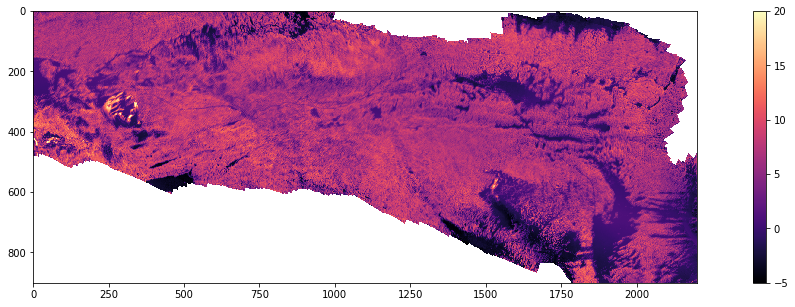

In [102]:
mean = np.nanmean(calCam,axis=2)
plt.figure(figsize=(20,5))
plt.imshow(mean, vmin=-5, vmax=20, cmap='magma')
plt.colorbar()
plt.savefig('mean.png',dip=600)

C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: All-NaN slice encountered
  """Entry point for launching an IPython kernel.
C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: All-NaN slice encountered
  


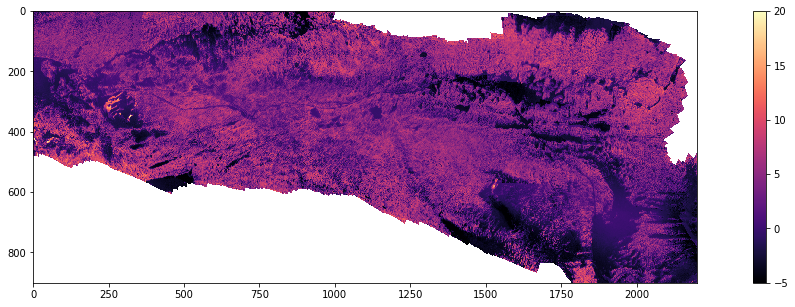

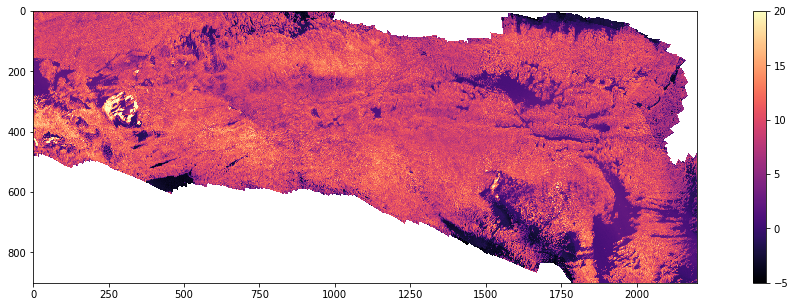

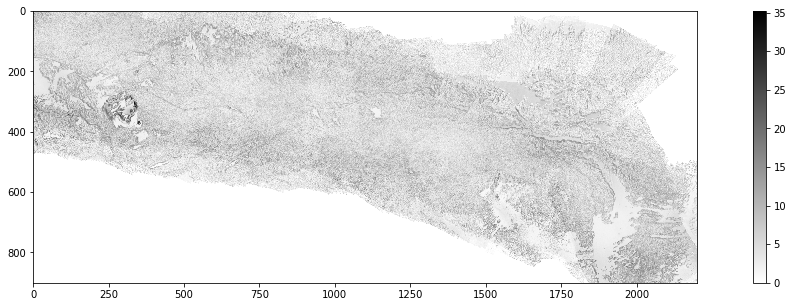

In [73]:
minimum = np.nanmin(calCam,axis=2)
maximum = np.nanmax(calCam,axis=2)
plt.figure(figsize=(20,5))
plt.imshow(minimum, vmin=-5, vmax=20, cmap='magma')
plt.colorbar()

plt.figure(figsize=(20,5))
plt.imshow(maximum, vmin=-5, vmax=20, cmap='magma')
plt.colorbar()

plt.figure(figsize=(20,5))
plt.imshow(maximum-minimum, cmap='gray_r')
plt.colorbar()
plt.savefig('range.png',dip=600)

C:\Users\steve\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


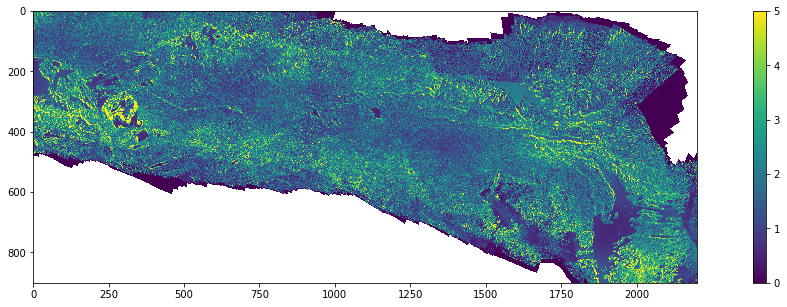

In [77]:
std = np.nanstd(calCam,axis=2)
plt.figure(figsize=(20,5))
plt.imshow(std, vmin=0, vmax=5)
plt.colorbar()
plt.savefig('std.png',dip=600)

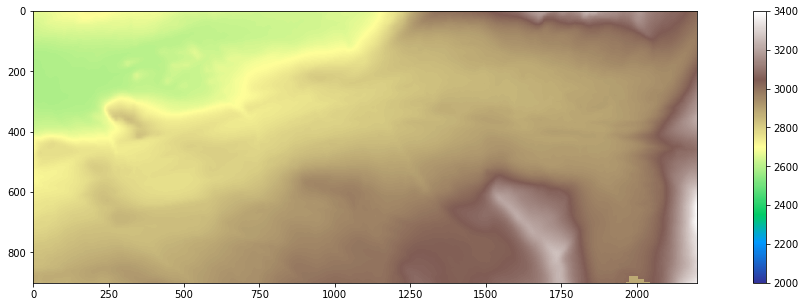

In [81]:
plt.figure(figsize=(20,5))
plt.imshow(Z, vmin=2000, vmax=3400, cmap='terrain')
plt.colorbar()

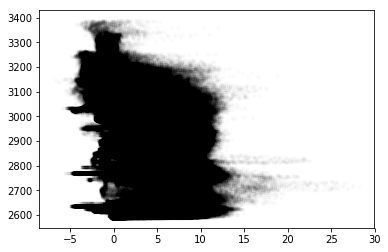

In [105]:
plt.plot(mean,Z,'.k',alpha=0.01);

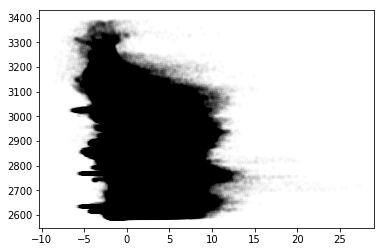

In [106]:
plt.plot(minimum,Z,'.k',alpha=0.01);

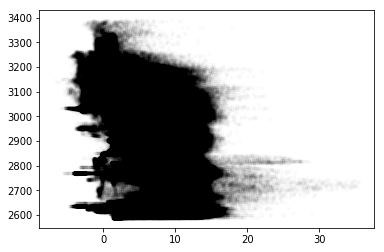

In [107]:
plt.plot(maximum,Z,'.k',alpha=0.01);

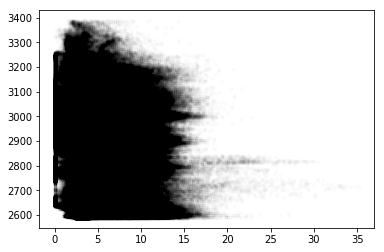

In [108]:
plt.plot(maximum-minimum,Z,'.k',alpha=0.01);

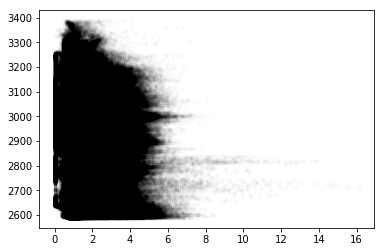

In [109]:
plt.plot(std,Z,'.k',alpha=0.01);

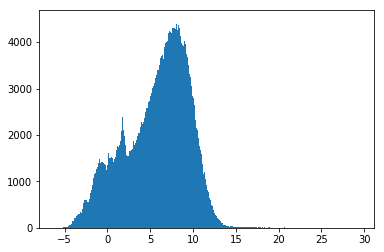

In [127]:
n= 7
plt.hist(calCam[~np.isnan(calCam[:,:,n]),n],1000);